In [21]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
import os
from PIL import Image
import torchvision.transforms as transforms

# Define the Generator class (same as in your training script)
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
nz = 100  # Size of the latent vector (input to the generator)
num_images = 50  # Number of images to generate
image_size = 128  # Size of the output image

# Initialize the generator
netG = Generator(nz).to(device)

# Load the saved model
netG.load_state_dict(torch.load('generator.pth', map_location=device))
netG.eval()  # Set to evaluation mode

# Create output directory if it doesn't exist
output_dir = 'high_quality_generated_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define image transformation for upscaling
upscale_transform = transforms.Compose([
    transforms.Resize(image_size, interpolation=Image.BICUBIC),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert grayscale to RGB
])

# Generate images
with torch.no_grad():
    for i in range(num_images):
        # Generate random noise
        noise = torch.randn(1, nz, 1, 1, device=device)
        
        # Generate fake image
        fake_image = netG(noise)
        
        # Rescale images to be between 0 and 1
        fake_image = (fake_image + 1) / 2.0
        
        # Upscale and convert to RGB
        fake_image = upscale_transform(fake_image.squeeze(0))
        
        # Save the image
        save_image(fake_image, f'{output_dir}/high_quality_generated_image_{i+1}.png', 
                   nrow=1, padding=0, normalize=False)

print(f"Generated {num_images} high-quality images in the '{output_dir}' directory.")

/tmp/ipykernel_917266/3099977080.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('generator.pth', map_location=device))


RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for main.0.weight: copying a param with shape torch.Size([120, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([100, 256, 4, 4]).

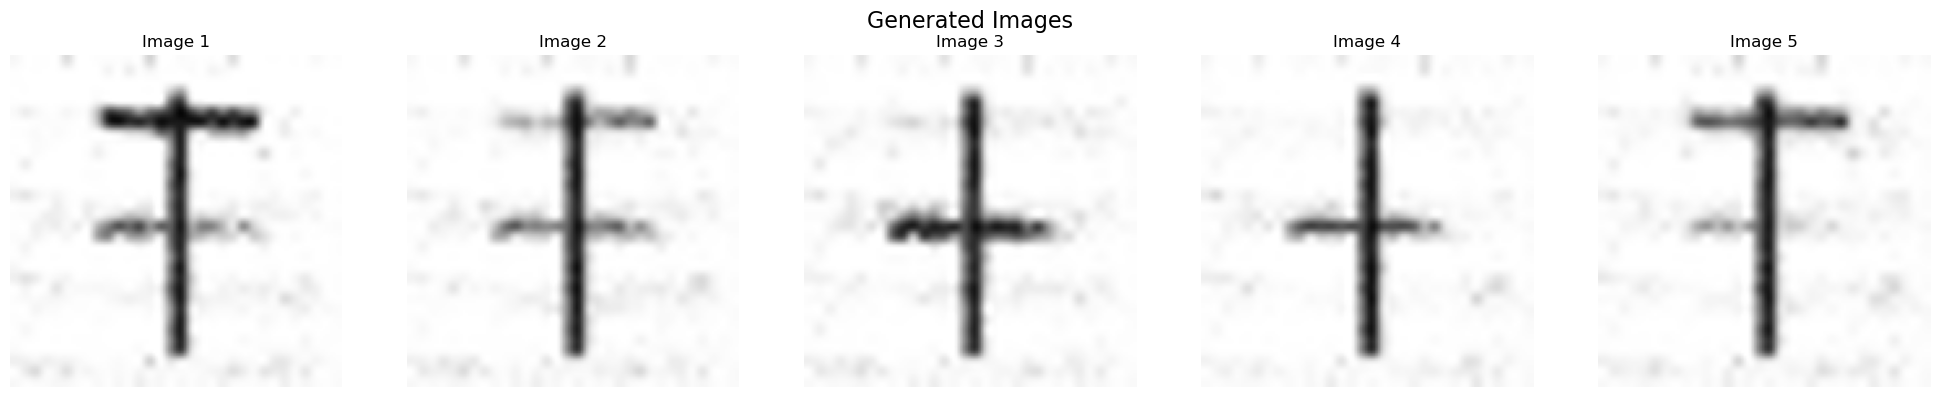

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Directory where the images are saved
image_dir = 'high_quality_generated_images'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Randomly select some images to display
num_images_to_show = 5
selected_images = random.sample(image_files, min(num_images_to_show, len(image_files)))

# Set up the plot
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
fig.suptitle('Generated Images', fontsize=16)

# Display each selected image
for i, image_file in enumerate(selected_images):
    img = Image.open(os.path.join(image_dir, image_file))
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()